# DALL·EとSegment Anythingを使用した動的マスクの作成方法

Segment AnythingはMetaが開発したモデルで、画像の一部分を選択するために使用できます。DALL·Eの画像の指定された部分をインペイントする機能と組み合わせることで、Segment Anythingを使用して変更したい画像の任意の部分を簡単に選択できます。

このノートブックでは、これらのツールを使用してファッションデザイナーになり、デジタルモデルの衣装を動的に置き換えて、オーダーメイドのオリジナル作品を作成します。ノートブックは以下の流れに従います：
- **セットアップ:** ライブラリと必要なディレクトリの場所を初期化します。
- **元画像の生成:** 動的マスクを作成する元となる画像を作成します。
- **マスクの生成:** Segment Anythingを使用して動的マスクを作成します。
- **新しい画像の作成:** マスクされた領域を新しいプロンプトでインペイントして新しい画像を生成します。

## セットアップ

開始するには、Metaがオープンソース化したSegment Anything（SAM）モデルを使用するための[手順](https://github.com/facebookresearch/segment-anything)に従う必要があります。2023年5月時点での主要な手順は以下の通りです：
- [Pytorch](https://pytorch.org/get-started/locally/)（バージョン1.7以上）をインストールする
- ```pip install git+https://github.com/facebookresearch/segment-anything.git```を使用してライブラリをインストールする
- ```pip install opencv-python pycocotools matplotlib onnxruntime onnx```を使用して依存関係をインストールする
- 使用する[モデルチェックポイント](https://github.com/facebookresearch/segment-anything#model-checkpoints)をダウンロードする（デフォルトサイズは2.4 GB）

In [ ]:
!pip install torch torchvision torchaudio
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx
!pip install requests
!pip install openai
!pip install numpy

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [3]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import numpy as np
from openai import OpenAI
import os
from PIL import Image
import requests
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import torch

# Set directories for generation images and edit images
base_image_dir = os.path.join("images", "01_generations")
mask_dir = os.path.join("images", "02_masks")
edit_image_dir = os.path.join("images", "03_edits")

# Point to your downloaded SAM model
sam_model_filepath = "./sam_vit_h_4b8939.pth"

# Initiate SAM model
sam = sam_model_registry["default"](checkpoint=sam_model_filepath)

# Initiate openAI client
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))


## オリジナル画像の生成

まず、マスクを生成するためのオリジナル画像を作成します。

In [4]:
def process_dalle_images(response, filename, image_dir):
    # save the images
    urls = [datum.url for datum in response.data]  # extract URLs
    images = [requests.get(url).content for url in urls]  # download images
    image_names = [f"{filename}_{i + 1}.png" for i in range(len(images))]  # create names
    filepaths = [os.path.join(image_dir, name) for name in image_names]  # create filepaths
    for image, filepath in zip(images, filepaths):  # loop through the variations
        with open(filepath, "wb") as image_file:  # open the file
            image_file.write(image)  # write the image to the file

    return filepaths

In [5]:
dalle_prompt = '''
Full length, zoomed out photo of our premium Lederhosen-inspired jumpsuit.
Showcase the intricate hand-stitched details and high-quality leather, while highlighting the perfect blend of Austrian heritage and modern fashion.
This piece appeals to a sophisticated, trendsetting audience who appreciates cultural fusion and innovative design.
'''

In [6]:
# Generate your images
generation_response = client.images.generate(
    model = "dall-e-3",
    prompt=dalle_prompt,
    n=3,
    size="1024x1024",
    response_format="url",
)

In [8]:
filepaths = process_dalle_images(generation_response, "generation", base_image_dir)

In [ ]:
# print the new generations
for filepath in filepaths:
    print(filepath)
    display(Image.open(filepath))

## マスクの生成

次に、画像の1つを読み込んでマスクを生成します。

このデモンストレーションでは、画像上のポイントを「クリック」してマスクを生成するUXを選択しています。ただし、Metaが提供している[サンプルノートブック](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb)では、画像のすべての可能なマスクを生成する方法、ボックスを描画する方法、その他の有用なアプローチが示されています。

In [10]:
# Pick one of your generated images
chosen_image = "images/01_generations/generation_2.png"

In [11]:
# Function to display mask using matplotlib
def show_mask(mask, ax):
    color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


# Function to display where we've "clicked"
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


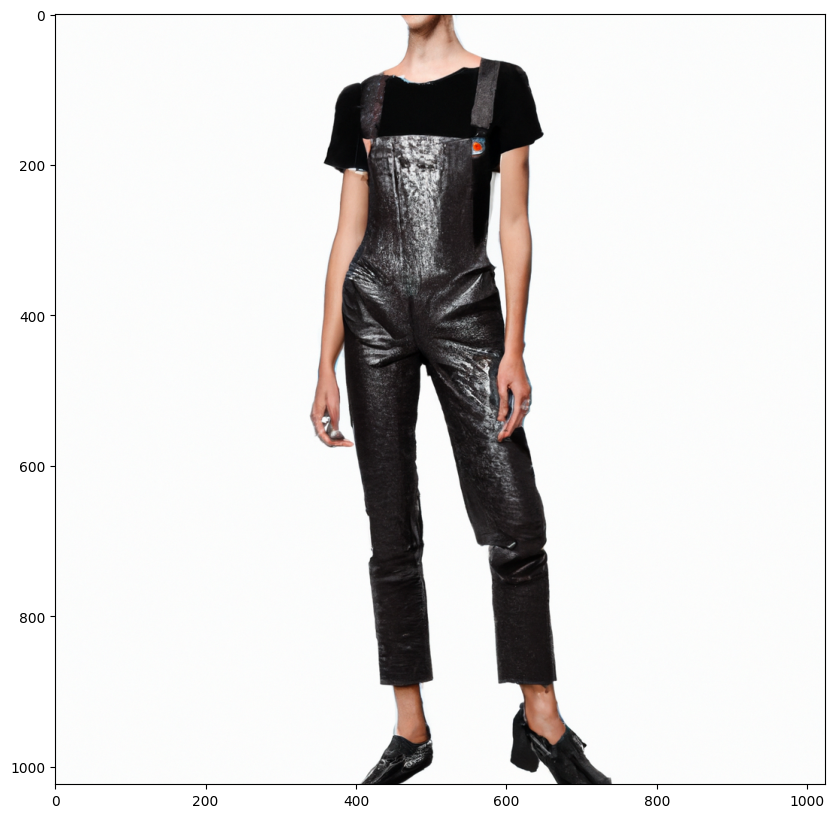

In [12]:
# Load chosen image using opencv
image = cv2.imread(chosen_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display our chosen image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("on")
plt.show()

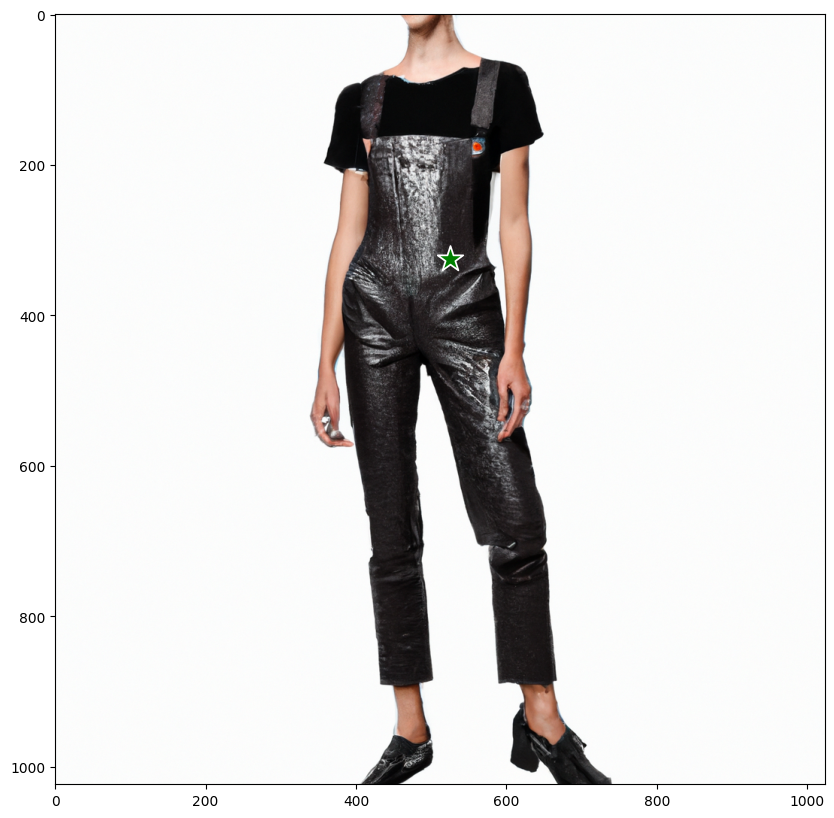

In [13]:
# Set the pixel coordinates for our "click" to assign masks
input_point = np.array([[525, 325]])
input_label = np.array([1])

# Display the point we've clicked on
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis("on")
plt.show()

In [14]:
# Initiate predictor with Segment Anything model
predictor = SamPredictor(sam)
predictor.set_image(image)

# Use the predictor to gather masks for the point we clicked
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

# Check the shape - should be three masks of the same dimensions as our image
masks.shape

(3, 1024, 1024)

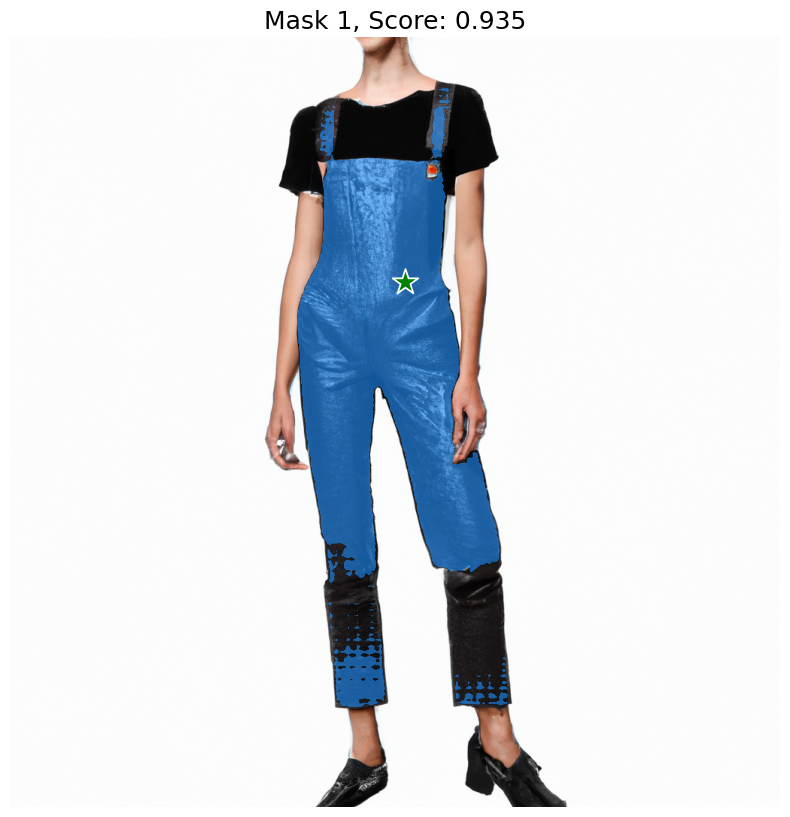

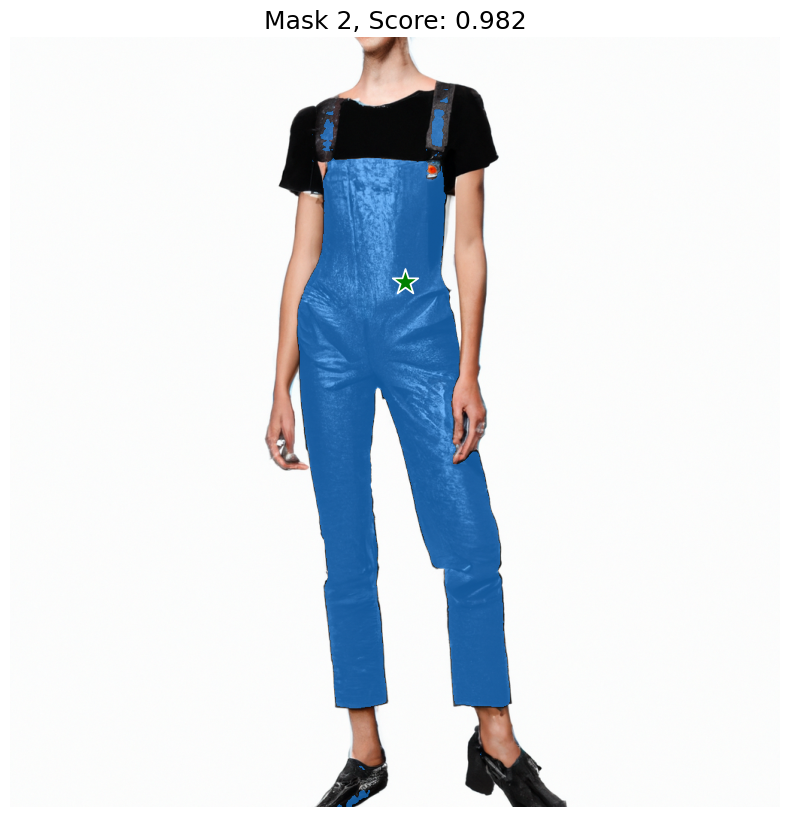

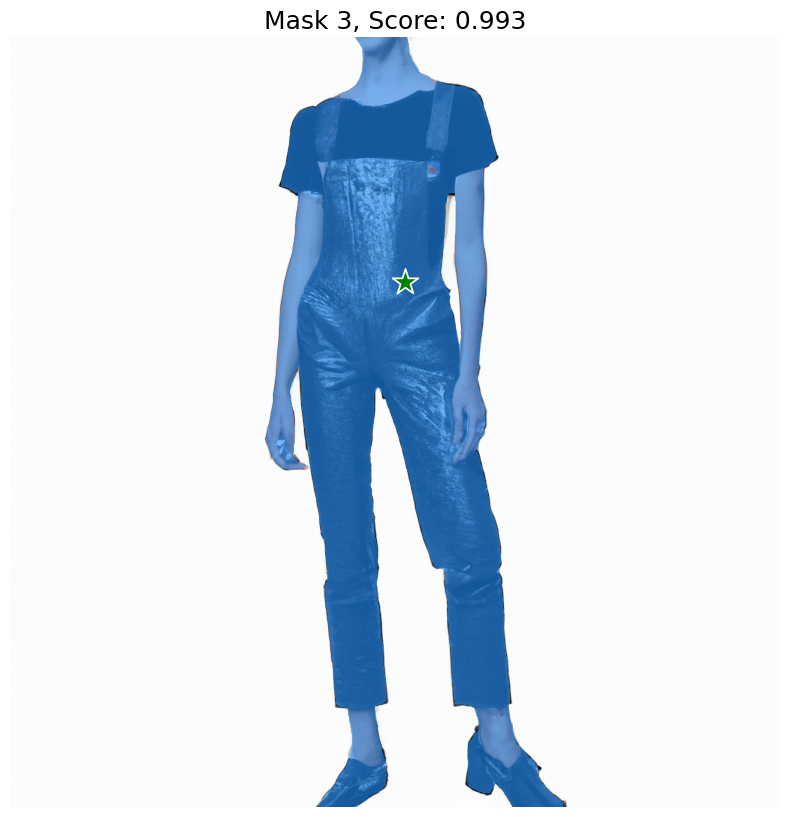

In [15]:
# Display the possible masks we can select along with their confidence
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis("off")
    plt.show()

In [16]:
# Choose which mask you'd like to use
chosen_mask = masks[1]

# We'll now reverse the mask so that it is clear and everything else is white
chosen_mask = chosen_mask.astype("uint8")
chosen_mask[chosen_mask != 0] = 255
chosen_mask[chosen_mask == 0] = 1
chosen_mask[chosen_mask == 255] = 0
chosen_mask[chosen_mask == 1] = 255


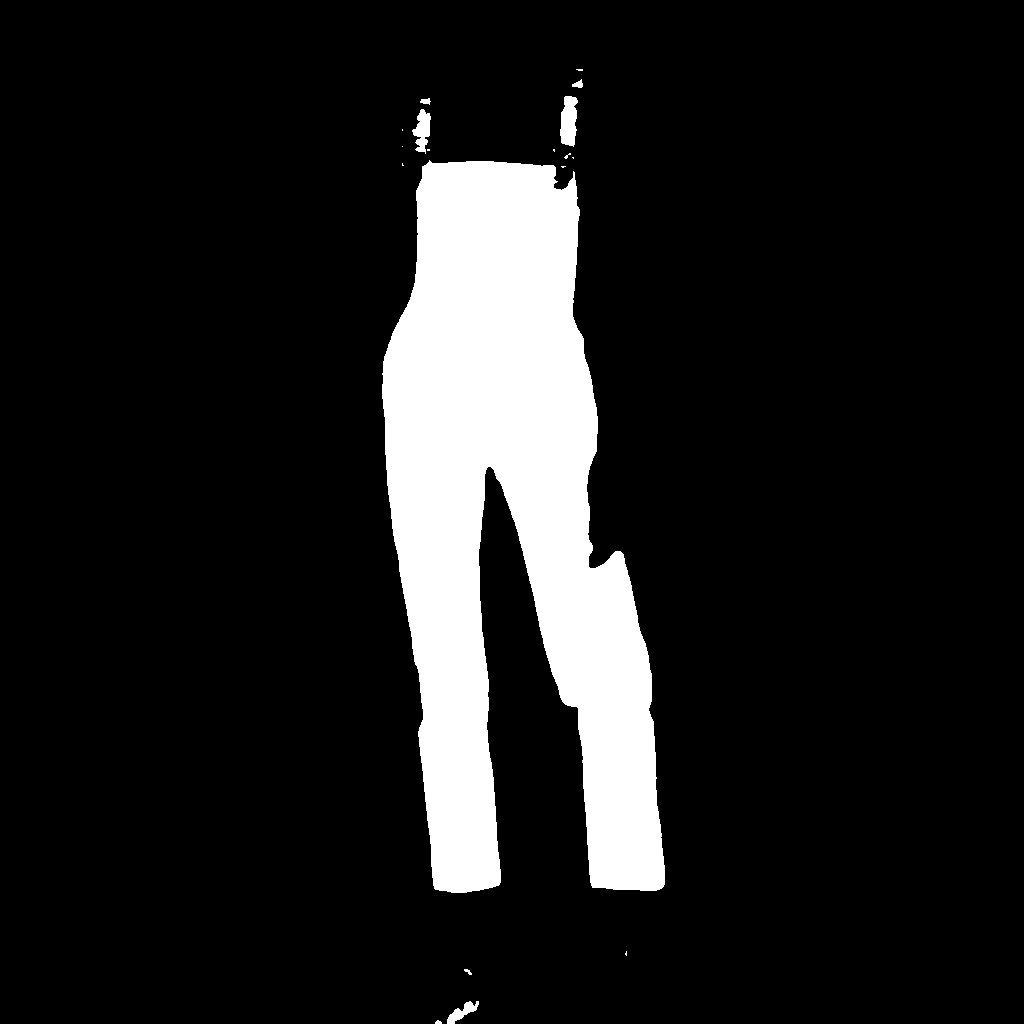

In [17]:
# create a base blank mask
width = 1024
height = 1024
mask = Image.new("RGBA", (width, height), (0, 0, 0, 1))  # create an opaque image mask

# Convert mask back to pixels to add our mask replacing the third dimension
pix = np.array(mask)
pix[:, :, 3] = chosen_mask

# Convert pixels back to an RGBA image and display
new_mask = Image.fromarray(pix, "RGBA")
new_mask

In [18]:
# We'll save this mask for re-use for our edit
new_mask.save(os.path.join(mask_dir, "new_mask.png"))

## 新しい画像を作成する

次に、元の画像とマスクを組み合わせて、DALLEのEditエンドポイントを使用し、新しいプロンプトに従って透明な領域をインペイントします。（2024年1月時点では、dall-e-2が編集をサポートする唯一のモデルです）

In [20]:
# edit an image
edit_response = client.images.edit(
    image=open(chosen_image, "rb"),  # from the generation section
    mask=open(os.path.join(mask_dir, "new_mask.png"), "rb"),  # from right above
    prompt="Brilliant leather Lederhosen with a formal look, detailed, intricate, photorealistic",  # provide a prompt to fill the space
    n=3,
    size="1024x1024",
    response_format="url",
)

edit_filepaths = process_dalle_images(edit_response, "edits", edit_image_dir)


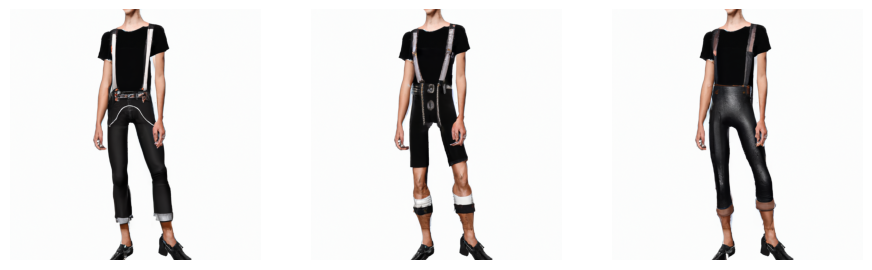

In [21]:
# Display your beautiful creations!
%matplotlib inline

# figure size in inches optional
rcParams["figure.figsize"] = 11 ,8

# read images
img_A = mpimg.imread(edit_filepaths[0])
img_B = mpimg.imread(edit_filepaths[1])
img_C = mpimg.imread(edit_filepaths[2])

# display images
fig, ax = plt.subplots(1,3)
[a.axis("off") for a in ax]
ax[0].imshow(img_A)
ax[1].imshow(img_B)
ax[2].imshow(img_C)

素晴らしい！

これで、あなたも簡単に動的マスクを作成して画像を拡張できるようになりました。APIをお楽しみください。そして、ぜひあなたが作ったものをシェアしてください！